In [40]:
import io
import os
import pickle
import requests
import numpy as np
import pandas as pd
from actsnfink import *
from shutil import copy
from copy import deepcopy
from astropy.time import Time
import matplotlib.pylab as plt
from distutils.dir_util import copy_tree
from sklearn.ensemble import RandomForestClassifier
from actsnclass.metrics import get_snpcc_metric
from actsnclass.metrics import get_snpcc_metric

In [2]:
fink_colors_list = ['#15284F','#F5622E','#D5D5D3','#3C8DFF']

# Initial configuration

In [3]:
train_first_model = False
strategy = 'UncSampling'            # query strategy

In [4]:
#AM
def plot_lc(list_lc,dir_suffix):
    fig = plt.figure(figsize=(12, 6))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in filtdic.keys():
        jd = lc.cjd[0][np.where(lc.cfid[0]==filt)[0]] - 2400000.5
        mag = lc.cmagpsf[0][np.where(lc.cfid[0]==filt)[0]]
        emag = lc.csigmapsf[0][np.where(lc.cfid[0]==filt)[0]]
        plt.errorbar(
            jd,
            mag,
            emag,
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )


    plt.gca().invert_yaxis()
    # plt.legend()
    plt.title(f"{str(list_lc['objectId'][0])} TNS: {str(list_lc['TNS'][0])}")
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')

    outdir = f'../plots/train_lcs_{dir_suffix}' if dir_suffix!="" else '../plots/train_lcs'
    
    os.makedirs(outdir, exist_ok=True)
    
    plt.savefig(f"{outdir}/{list_lc['objectId'][0]}")

In [44]:
def AL_loop(new_labels, train_for_loop, dir_suffix ="", proba_cut = True, plot_lcs=False):

    dir_output= f'../data_{dir_suffix}/' if dir_suffix!="" else  '../data/'

    if not os.path.exists(f"{dir_output}/initial_state"):
        print("No path",f"{dir_output}/initial_state")
        os.makedirs(dir_output, exist_ok=True)
        # copy initial state
        copy_tree("../data/initial_state", f"{dir_output}/initial_state")
    
    time_counter = 0
    metrics_all_list = []
    probabilities_list = []

    for d, date in enumerate(list(new_labels.keys())):
    
        print(date)
        
        # read previous training sample and trained model
        if date == list(new_labels.keys())[0]:
            train_for_loop = pd.read_csv(dir_output + 'initial_state/' + strategy + \
                                               '/training_samples/train_after_loop.csv', 
                                               index_col=False)
            
            clf_before = pickle.load(open(dir_output + 'initial_state/' + strategy + \
                                               '/models/model.pkl', 'rb'))
        else:
            is_file = False
            indx = list(new_labels.keys()).index(date) - 1
            
            while not is_file and indx >= 0:
                
                date_before = list(new_labels.keys())[indx]
                is_file = os.path.isfile(dir_output + date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/train.csv')
                if is_file:
                    train_for_loop = pd.read_csv(dir_output +  date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/train.csv', 
                                              index_col=False)    
            
                    clf_before = pickle.load(open(dir_output +  date_before + '/' + strategy + \
                                               '/models/model.pkl', 'rb'))
                else:
                    indx = indx - 1
    
        ########################################################################
        ### create directory structure
        dirname_output = dir_output +  date + '/'
        
        for name in [dirname_output + '/', 
                     dirname_output + '/' + strategy + '/', 
                     dirname_output + '/' + strategy + '/models/', 
                     dirname_output + '/' + strategy + '/class_prob/',
                     dirname_output + '/' + strategy + '/metrics/', 
                     dirname_output + '/' + strategy + '/queries/',
                     dirname_output + '/' + strategy + '/training_samples/', 
                     dirname_output + '/' + strategy + '/test_samples/']:
            if not os.path.isdir(name):
                os.makedirs(name)
    
        #######################################################################
        ### Get alert data
        
        alerts_list = []
    
        for i in range(new_labels[date].shape[0]):
            
            name = new_labels[date][i][0]
            # print(name)
    
            r = requests.post(
                'https://fink-portal.org/api/v1/objects',
                json={
                    'objectId':name,
                    'output-format': 'json'
                }
            )

            try:
                # Format output in a DataFrame
                pdf = pd.read_json(io.BytesIO(r.content))
            except Exception:
                pdf= pd.DataFrame()
    
            if pdf.shape[0] == 0:
                print(f"No alerts found for object: {name}")
                # raise ValueError('No alerts found for object: ', name)
            else:
                # add label
                pdf['type'] = new_labels[date][i][1] 
        
                alerts_list.append(pdf)
    
        if len(alerts_list)>0:
            alerts_pd = pd.concat(alerts_list, ignore_index=True)
        
        
            #############################################################################
            #### feature extract for each date
            
            alerts_format_list = []
        
            for indx_obj in range(new_labels[date].shape[0]):
                
                # isolate one object
                flag_obj = alerts_pd['i:objectId'].values == new_labels[date][indx_obj][0]
        
                # separate only dates until the alert was sent to follow-up
                cjd = alerts_pd[flag_obj]['i:jd'].values
                flag_jd = cjd < float(new_labels[date][indx_obj][2])

                # for ZTF, some light-curves were not available before classification
                if len(alerts_pd[flag_obj]['i:jd'].values[flag_jd])>0: 
                    
                    #flag_jd = np.array([True for i in range(cjd.shape[0])])
                    lc = pd.DataFrame([[new_labels[date][indx_obj][0], 
                                    alerts_pd[flag_obj]['i:candid'].values[flag_jd][np.argsort(alerts_pd[flag_obj]['i:jd'].values[flag_jd])[-1]],
                                    alerts_pd[flag_obj]['i:jd'].values[flag_jd],         
                                    alerts_pd[flag_obj]['i:fid'].values[flag_jd], 
                                    alerts_pd[flag_obj]['i:magpsf'].values[flag_jd],
                                    alerts_pd[flag_obj]['i:sigmapsf'].values[flag_jd],
                                    new_labels[date][indx_obj][1]]], 
                                    columns=['objectId', 'candid', 'cjd', 'cfid', 'cmagpsf', 'csigmapsf', 'TNS'], index=[0], dtype=object)
                
                    alerts_format_list.append(lc)
                    
                    if plot_lcs:
                        plot_lc(lc)
                        
            if len(alerts_format_list)>0:
                alerts_format_pd = pd.concat(alerts_format_list, ignore_index=True)
            
                
                # convert from mag to FLUXCAL
                alerts_flux = convert_full_dataset(alerts_format_pd, obj_id_header='objectId')
            
                # extract features
                alerts_features = featurize_full_dataset(alerts_flux, screen=False,
                                                         ewma_window=3, 
                                                          min_rising_points=1, 
                                                          min_data_points=3, rising_criteria='ewma')
            
            
            
                # filter alerts with zero in all filters
                flag_zero = np.logical_and(alerts_features['a_g'].values == 0.0,
                                           alerts_features['a_r'].values == 0.0)
                # flag_zero = np.logical_or(alerts_features['a_g'].values == 0.0,
                #                            alerts_features['a_r'].values == 0.0)
            
                alerts_use = deepcopy(alerts_features[~flag_zero])
                # print('    alerts_use.shape = ', alerts_use.shape)
            
                # go through events if they have at least one band with features
                if alerts_use.shape[0] > 0:
                    alerts_use.rename(columns={'id':'objectId'}, inplace=True)
                    alerts_use['loop'] = list(new_labels.keys()).index(date) + 30
                
                    # see what current model says about queried alerts
                    pred_prob_query = clf_before.predict_proba(alerts_use[list(alerts_use.keys())[2:-1]])
                    print(f'Proba {pred_prob_query}')
        
                    if proba_cut:
                        keep_index = []
                        for j in range(len(pred_prob_query)):
                            if (pred_prob_query[j][0]>0.4) & (pred_prob_query[j][0]<0.6):
                                keep_index.append(j)
                        new_alerts_use = alerts_use.iloc[keep_index]
                        probabilities_list.append(pred_prob_query[j][0])
                    else:
                        new_alerts_use = alerts_use
                        probabilities_list.append(pred_prob_query)
            
                    if len(new_alerts_use) > 0:
                                              
                        # update training
                        train_updated = pd.concat([train_for_loop, new_alerts_use], ignore_index=True)
                        print('    train_updated.shape = ', train_updated.shape)
            
                        # save to file
                        train_updated.to_csv(dir_output + date +'/' + strategy  + \
                                                          '/training_samples/train.csv', 
                                                           index=False)
                    
                        # train model
                        clf = RandomForestClassifier(random_state=42, n_estimators=1000)
                        clf.fit(train_updated[list(train_updated.keys())[:-3]], 
                                    train_updated['type'].values == 'Ia')
                    
                        # make predictions
                        pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
                        pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])
                        
                        # save mode
                        pickle.dump(clf, open(dir_output + date + '/' + strategy + '/models/model.pkl', 
                                                  'wb'))
                    
                        # save predictions
                        pred_prob_pd = pd.DataFrame(np.hstack([test_for_loop['objectId'].values.reshape(-1,1), 
                                                        np.array(pred_prob[:,1]).reshape(-1,1)]), 
                                                        columns=['objectId','probIa'])
                        pred_prob_pd.to_csv(dir_output +  date + '/' + strategy + \
                                            '/class_prob/test_class_prob.csv', index=False)
                
                        # calculate metrics
                        names, res = get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')
                        print('   res = ', res)
                        
                        metric_pd = pd.DataFrame([[date] + [list(new_labels.keys()).index(date) + 30] + res + \
                                                     [list(alerts_use['objectId'].values)]],
                                                    columns=['date','loop'] + names + ['query_objectIds'])
                        metric_pd.to_csv(dir_output +  date +'/' + strategy  + \
                                                          '/metrics/metric.csv', 
                                                           index=False)
                        metric_pd['date_plot'] = d 
                        metrics_all_list.append(metric_pd)
                        
    if len(metrics_all_list)>0:        
        metrics = pd.concat(metrics_all_list, ignore_index=True)

    else:
        metrics = pd.DataFrame()

    return metrics, probabilities_list

In [6]:
# read train and test data for loop
train_for_loop = pd.read_csv( '../data/initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)

test_for_loop = pd.read_csv('../data/initial_state/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index_col=False)

In [7]:
test_for_loop['type'].unique()
type_list = ['SN','SNII','Ia', 'SLSN-I','SNIIP', 'SNIIn', 'SLSN-II', 'SNIc', 'SNIb', 'SNIIb', 'SNI','SNIb-pec', 'SNIc-BL','SNII-pec','SNIbn']
test_for_loop = test_for_loop[test_for_loop['type'].isin(type_list)]

In [8]:
# train model
clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(train_for_loop[list(train_for_loop.keys())[:-3]], train_for_loop['type'].values == 'Ia')

RandomForestClassifier(n_estimators=1000, random_state=42)

In [9]:
# make predictions
pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])

# calculate metrics
get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [np.float64(0.4739316239316239),
  np.float64(0.26212980466288593),
  np.float64(0.8739495798319328),
  np.float64(0.18296308513382645)])

In [10]:
# save mode
pickle.dump(clf, open('../data/initial_state/' + strategy + '/models/model.pkl', 
                      'wb'))

In [11]:
# labels from 2.3m SSO, Australia
# here I used the date one day after it was sent to make sure to include all points regardless
# of when the night started

new_labels = {}
new_labels['20230921'] = np.array([['ZTF23abecphw', 'other', Time('2023-09-25', format='iso').jd]])
new_labels['20230925'] = np.array([['ZTF23abdhvou', 'Ia', Time('2023-09-26', format='iso').jd]])
new_labels['20230928'] = np.array([['ZTF23abceaws', 'other', Time('2023-10-01', format='iso').jd]])
new_labels['20231005'] = np.array([['ZTF23abhtkba', 'other', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abeudve', 'Ia', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abggbdy', 'Ia', Time('2023-10-06', format='iso').jd]])
new_labels['20231006'] = np.array([['ZTF23abghfyg', 'Ia', Time('2023-10-07', format='iso').jd]])
new_labels['20231009'] = np.array([['ZTF23abhafym', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgspys', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abglsmj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgfwhj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abhublj', 'Ia', Time('2023-10-10', format='iso').jd]])

new_labels['20231013'] = np.array([['ZTF23abgspvs', 'Ia', Time('2023-10-14', format='iso').jd],
                                   ['ZTF23abgnfdv', 'Ia', Time('2023-10-14', format='iso').jd],
                                  ['ZTF23abhzwll', 'Ia', Time('2023-10-14', format='iso').jd]])
                                   
new_labels['20231015'] = np.array([['ZTF23abhailb', 'other', Time('2023-10-16', format='iso').jd]])
                                  # ['ZTF23abgfwhj', 'Ia', Time('2023-10-16', format='iso').jd]])
new_labels['20231016'] = np.array([['ZTF23abihzbq', 'Ia', Time('2023-10-17', format='iso').jd]])
new_labels['20231018'] = np.array([['ZTF23abhvsbo', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abiljba', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzlbh', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abixwfv', 'other', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abidsaw', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzoyw', 'Ia', Time('2023-10-19', format='iso').jd]])
new_labels['20231019'] = np.array([['ZTF23abkavcl', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abjzkqu', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abkgdei', 'Ia', Time('2023-10-20', format='iso').jd],
                                   # ['ZTF23abidmwl', 'other', Time('2023-10-20', format='iso').jd],
                                  ['ZTF23abjhbcr', 'other', Time('2023-10-20', format='iso').jd]])
new_labels['20231022'] = np.array([['ZTF23abjtozz', 'Ia', Time('2023-10-23', format='iso').jd]])
new_labels['20240224'] = np.array([['ZTF24aaejkyp', 'other', Time('2024-02-25', format='iso').jd]])
new_labels['20240229'] = np.array([['ZTF24aaegskb', 'Ia', Time('2024-03-01', format='iso').jd]])
new_labels['20240404'] = np.array([['ZTF24aahgtjt', 'Ia', Time('2024-04-05', format='iso').jd]])
new_labels['20240405'] = np.array([['ZTF24aahgqwk', 'other', Time('2024-04-06', format='iso').jd]])
new_labels['20240409'] = np.array([['ZTF24aahznij', 'Ia', Time('2024-04-10', format='iso').jd],
                                  ['ZTF24aahuulq', 'Ia', Time('2024-04-10', format='iso').jd]])
new_labels['20240410'] = np.array([['ZTF24aaiftcp', 'Ia', Time('2024-04-11', format='iso').jd],
                                  ['ZTF24aaiehwu', 'Ia', Time('2024-04-11', format='iso').jd]])
new_labels['20240412'] = np.array([['ZTF24aaindpx', 'Ia', Time('2024-04-13', format='iso').jd]])
new_labels['20240413'] = np.array([['ZTF24aaiypmp', 'Ia', Time('2024-04-14', format='iso').jd]])
new_labels['20240414'] = np.array([['ZTF24aahtdhb', 'other', Time('2024-04-15', format='iso').jd]]) #AM
new_labels['20240417'] = np.array([['ZTF24aaieino', 'Ia', Time('2024-04-18', format='iso').jd],])
                                  # ['ZTF24aahznij', 'Ia', Time('2024-04-18', format='iso').jd]]) # already in previous days
new_labels['20240418'] = np.array([['ZTF24aaiigrt', 'Ia', Time('2024-04-21', format='iso').jd],
                                  ['ZTF24aaiafkl', 'other', Time('2024-04-19', format='iso').jd]])
new_labels['20240421'] = np.array([['ZTF24aaikjjk', 'other', Time('2024-04-22', format='iso').jd]])
new_labels['20240423'] = np.array([['ZTF24aajqamj', 'other', Time('2024-04-24', format='iso').jd]])
new_labels['20240503'] = np.array([['ZTF24aajwajo', 'other', Time('2024-05-04', format='iso').jd],
                                  ['ZTF24aajqwsm', 'Ia', Time('2024-05-04', format='iso').jd]])
new_labels['20240504'] = np.array([['ZTF24aakfchb', 'other', Time('2024-05-05', format='iso').jd]])
new_labels['20240505'] = np.array([['ZTF24aakymro', 'Ia', Time('2024-05-06', format='iso').jd]])
new_labels['20240507'] = np.array([['ZTF24aalhjeu', 'other', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalhjml', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalsuwb', 'Ia', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalcflg', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalpgky', 'other', Time('2024-05-08', format='iso').jd]])
new_labels['20240508'] = np.array([['ZTF24aakyqxt', 'Ia', Time('2024-05-09', format='iso').jd],
                                   ['ZTF24aalbzkr', 'Ia', Time('2024-05-09', format='iso').jd]])
new_labels['20240510'] = np.array([['ZTF24aalbkdo', 'Ia', Time('2024-05-11', format='iso').jd]])
new_labels['20240514'] = np.array([['ZTF24aamtsgz', 'Ia', Time('2024-05-15', format='iso').jd]])
new_labels['20240515'] = np.array([['ZTF24aamdfll', 'Ia', Time('2024-05-16', format='iso').jd]])
new_labels['20240521'] = np.array([['ZTF24aaomuhe', 'Ia', Time('2024-05-22', format='iso').jd]])
new_labels['20240601'] = np.array([['ZTF24aaoxbth', 'Ia', Time('2024-06-02', format='iso').jd]])
new_labels['20240622'] = np.array([['ZTF24aarfccy', 'Ia', Time('2024-06-23', format='iso').jd]])
new_labels['20240623'] = np.array([['ZTF24aarwwnc', 'other', Time('2024-06-24', format='iso').jd]])
new_labels['20240624'] = np.array([['ZTF24aasfxgh', 'Ia', Time('2024-06-25', format='iso').jd]])
new_labels['20240627'] = np.array([['ZTF24aaqutdf', 'other', Time('2024-06-28', format='iso').jd]])
new_labels['20240628'] = np.array([['ZTF24aasmghi', 'Ia', Time('2024-06-29', format='iso').jd]])
new_labels['20240703'] = np.array([['ZTF24aatkrrw', 'other', Time('2024-07-04', format='iso').jd]])
new_labels['20240706'] = np.array([['ZTF24aatfxrw', 'Ia', Time('2024-07-07', format='iso').jd]])



In [12]:
metrics_all_pd, probabilities_list_all = AL_loop(new_labels, train_for_loop, dir_suffix ="", proba_cut = False, plot_lcs=False)

20230921
Proba [[0.374 0.626]]
    train_updated.shape =  (41, 15)
   res =  [np.float64(0.4623931623931624), np.float64(0.23944549464398235), np.float64(0.8816705336426914), np.float64(0.17071160968989363)]
20230925
Proba [[0.479 0.521]]
    train_updated.shape =  (42, 15)
   res =  [np.float64(0.461965811965812), np.float64(0.2432262129804663), np.float64(0.8693693693693694), np.float64(0.16765235394724995)]
20230928
20231005
Proba [[0.256 0.744]
 [0.609 0.391]
 [0.31  0.69 ]]
    train_updated.shape =  (45, 15)
   res =  [np.float64(0.4948717948717949), np.float64(0.29930686830497794), np.float64(0.8715596330275229), np.float64(0.20754855831367086)]
20231006
Proba [[0.624 0.376]]
    train_updated.shape =  (46, 15)
   res =  [np.float64(0.4888888888888889), np.float64(0.2942659105229994), np.float64(0.860036832412523), np.float64(0.19772975570394344)]
20231009
Proba [[0.416 0.584]
 [0.168 0.832]
 [0.469 0.531]
 [0.572 0.428]]
    train_updated.shape =  (50, 15)
   res =  [np.float64

In [13]:
# AM wants to see if numebr of spectra makes sense
# metrics_all_pd

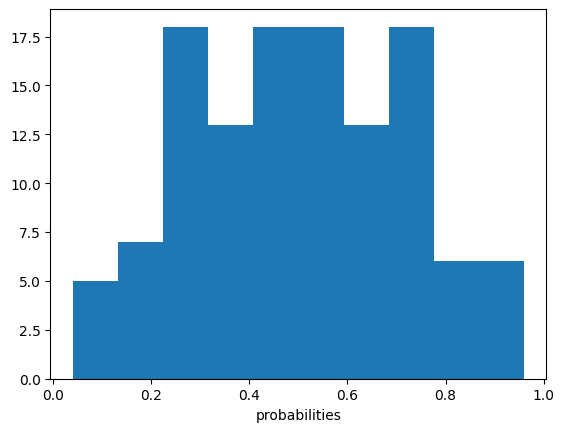

In [14]:
probabilities_list_all_flat = np.concatenate(probabilities_list_all).ravel().tolist()
plt.hist(probabilities_list_all_flat)
plt.xlabel('probabilities')
plt.savefig('../data/probabilities.png')

In [15]:
metrics_all_pd.to_csv('../data/' + 'metrics.csv', index=False)

# Fink all + Probability cut

In [45]:
metrics_probacut, probabilities_list_probacut = AL_loop(new_labels, train_for_loop, dir_suffix='probacut', proba_cut = True)

No path ../data_probacut//initial_state
20230921
Proba [[0.374 0.626]]
20230925
Proba [[0.479 0.521]]
    train_updated.shape =  (42, 15)
   res =  [np.float64(0.461965811965812), np.float64(0.2432262129804663), np.float64(0.8693693693693694), np.float64(0.16765235394724995)]
20230928
20231005
Proba [[0.256 0.744]
 [0.609 0.391]
 [0.31  0.69 ]]
20231006
Proba [[0.66 0.34]]
20231009
Proba [[0.4   0.6  ]
 [0.209 0.791]
 [0.486 0.514]
 [0.551 0.449]]
    train_updated.shape =  (47, 15)
   res =  [np.float64(0.48205128205128206), np.float64(0.28796471329552614), np.float64(0.8478664192949907), np.float64(0.18719754477390532)]
20231013
Proba [[0.438 0.562]
 [0.568 0.432]
 [0.417 0.583]]
    train_updated.shape =  (50, 15)
   res =  [np.float64(0.5145299145299145), np.float64(0.34908632640201637), np.float64(0.8432267884322678), np.float64(0.2240948143994404)]
20231015
Proba [[0.308 0.692]]
20231016
Proba [[0.279 0.721]]
20231018
Proba [[0.7   0.3  ]
 [0.441 0.559]
 [0.477 0.523]
 [0.445 0.5

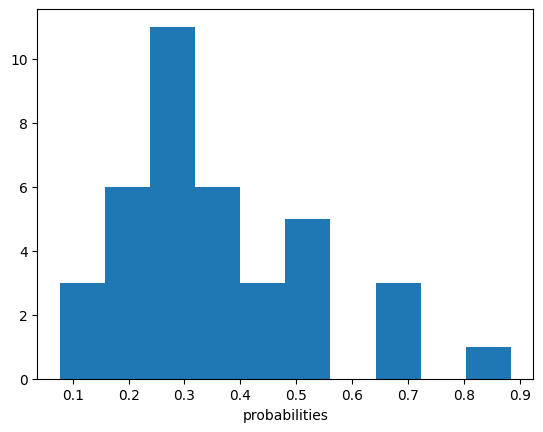

In [46]:
# probabilities_list_allprobacut_flat = np.concatenate(probabilities_list_probacut).ravel().tolist()
probabilities_list_allprobacut_flat = [float(k) for k in probabilities_list_probacut]
plt.hist(probabilities_list_allprobacut_flat)
plt.xlabel('probabilities')
plt.savefig('../data_probacut/probabilities.png')

# With spec classified by ZTF


is it a good comaprisson by date? because there is a lot mroe spectra here, so maybe a fairer comparison is by number of spectra added.... but lets see the results.

In [178]:
# Function to convert Time object to desired format
from astropy.time import TimeDelta
def add_days_and_format(x,days):
    # Convert Time object to datetime
    time_obj = Time(x, format='iso') + TimeDelta(days, format='jd')
    dt = time_obj.datetime 
    # dt = time_obj.datetime
    # Format datetime to custom format
    return f"{dt.year}{dt.month:02d}{dt.day:02d}"

In [179]:
tmp1= pd.read_csv('../tns/tns-ZTFfoundandclassed_20230921_20231020.csv')
tmp2 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240216_20240230.csv')
tmp3 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240424_20240629.csv')

tmp = pd.concat([tmp1,tmp2,tmp3],ignore_index=True)
tmp['type'] = tmp['Obj. Type'].str.strip('SN ')
tmp['type AL'] = tmp['type'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')
tmp['discoveryjd'] = [Time(d, format='iso').jd for d in tmp['Discovery Date (UT)']]
tmp['discoveryjd+12'] = tmp['discoveryjd'].apply(lambda x: int(x+12)) # 12 dayas as time to get ~3 measurements in each band
tmp['discoveryjd+12_strfmt'] = tmp['Discovery Date (UT)'].apply(lambda x: add_days_and_format(x, 12))
# may need to change formatting to keep date format but without decimals...

In [180]:
ztf_tns = tmp[['Disc. Internal Name','type AL','discoveryjd+12','discoveryjd+12_strfmt']]

In [183]:
# convert to new_labels format
dic_ztf_labels = {}
for dat in ztf_tns['discoveryjd+12'].unique():
    sel = ztf_tns[ztf_tns['discoveryjd+12']==dat]
    tmp_arr = sel[['Disc. Internal Name','type AL','discoveryjd+12']].to_numpy()

    date_in_str_fmt = sel['discoveryjd+12_strfmt'].values[0]
    dic_ztf_labels[date_in_str_fmt] = tmp_arr

In [184]:
metrics_ztf, probabilities_list_ztf = AL_loop(dic_ztf_labels, train_for_loop, dir_suffix='ZTF', proba_cut = False)

20231025
Proba [[0.322 0.678]]
    train_updated.shape =  (41, 15)
   res =  [np.float64(0.49230769230769234), np.float64(0.2942659105229994), np.float64(0.8728971962616823), np.float64(0.20480205695117837)]
20231006
20231017
20231027
Proba [[0.161 0.839]
 [0.515 0.485]
 [0.663 0.337]]
    train_updated.shape =  (44, 15)
   res =  [np.float64(0.4495726495726496), np.float64(0.22432262129804661), np.float64(0.8619854721549637), np.float64(0.1515348257724945)]
20231021
Proba [[0.381 0.619]]
    train_updated.shape =  (45, 15)
   res =  [np.float64(0.43504273504273505), np.float64(0.19155639571518587), np.float64(0.8862973760932945), np.float64(0.13832100783234325)]
20231016
Proba [[0.401 0.599]]
    train_updated.shape =  (46, 15)
   res =  [np.float64(0.4354700854700855), np.float64(0.19155639571518587), np.float64(0.8888888888888888), np.float64(0.139313742338317)]
20240706
20240707
Proba [[0.548 0.452]]
    train_updated.shape =  (47, 15)
   res =  [np.float64(0.45), np.float64(0.2205

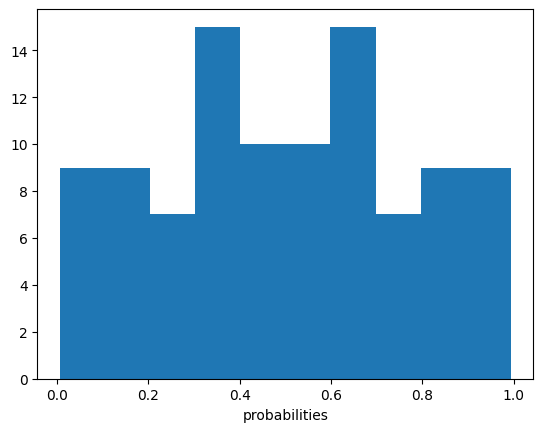

In [185]:
probabilities_list_ZTF_flat = np.concatenate(probabilities_list_ztf).ravel().tolist()
plt.hist(probabilities_list_ZTF_flat)
plt.xlabel('probabilities')
plt.savefig('../data_ZTF/probabilities.png')

In [186]:
print('Comparing how many spectra are available in the different samples')
print(f'ZTF {len(probabilities_list_ZTF_flat)}')
print(f'Fink {len(probabilities_list_all_flat)}')
print(f'Fink prob {len(probabilities_list_allprobacut_flat)}')

Comparing how many spectra are available in the different samples
ZTF 100
Fink 122
Fink prob 38


In [269]:
def plot_metrics_listdf(list_df,label_list,plots_dir='./', varx='date_plot',suffix=''):
    plt.figure(figsize=(16,10))
    
    for i,df in enumerate(list_df):

        color_to_use = fink_colors_list[i] #if label_list[i]!='ztf all' else 'red'
        xlabel = 'date' if varx=='date_plot' else varx

        # to be implemented
        if varx=='n spectra':
            df['n spectra']= df['query_objectIds'].apply(lambda x: len(x)).cumsum()
        
        plt.subplot(2,2,1)
        plt.scatter(df[varx].astype(int), df['accuracy'],label=label_list[i],color=color_to_use)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel('accuracy')
        
        plt.subplot(2,2,2)
        plt.scatter(df[varx].astype(int), df['efficiency'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('efficiency')
        
        plt.subplot(2,2,3)
        plt.scatter(df[varx].astype(int), df['purity'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('purity')
        
        plt.subplot(2,2,4)
        plt.scatter(df[varx].astype(int), df['fom'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('figure of merit')

    
    plt.savefig(f'{plots_dir}/metrics_superposed_{varx}{suffix}.png')    
    plt.show()

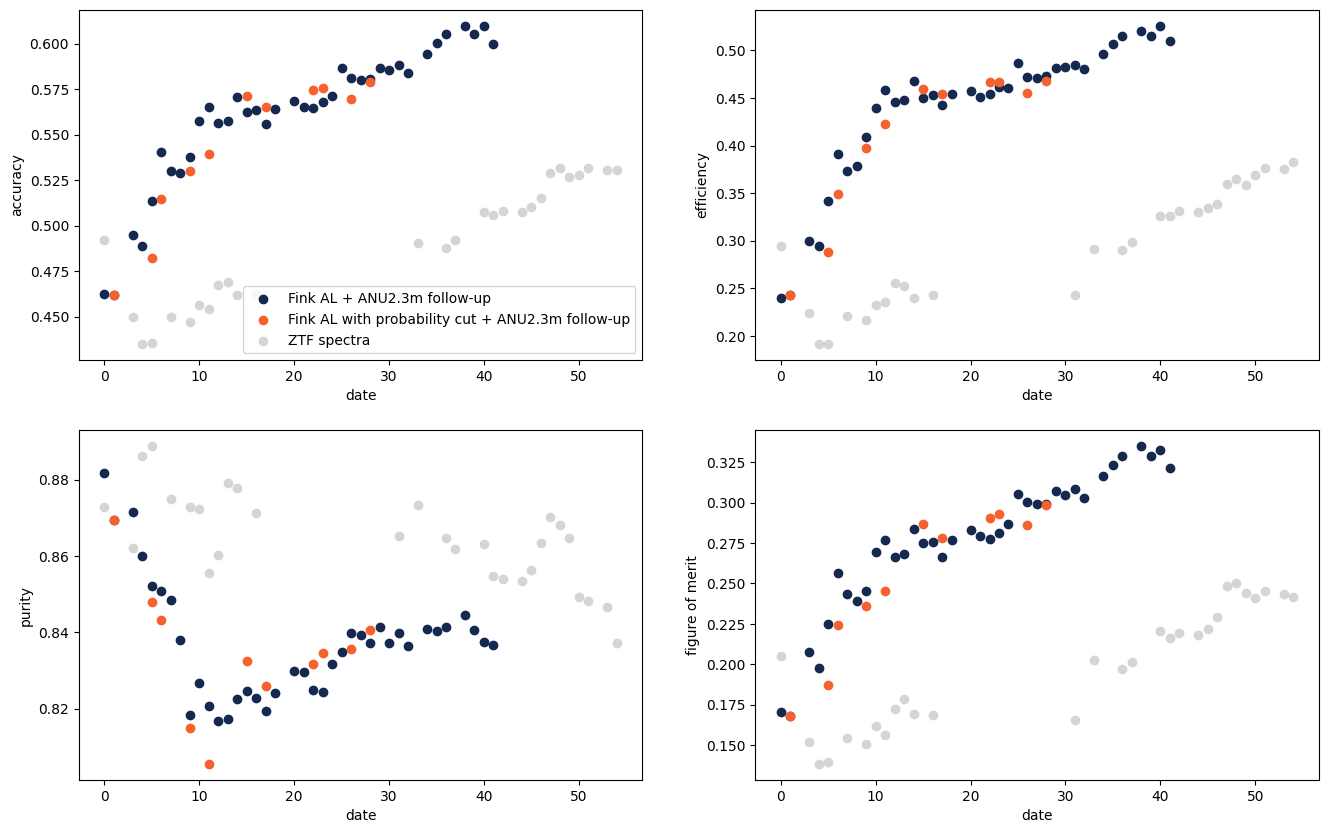

In [272]:
# not completely true as ZTF spectra dates are different than Fink AL ones
plot_metrics_listdf([metrics_all_pd,metrics_probacut,metrics_ztf],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'])

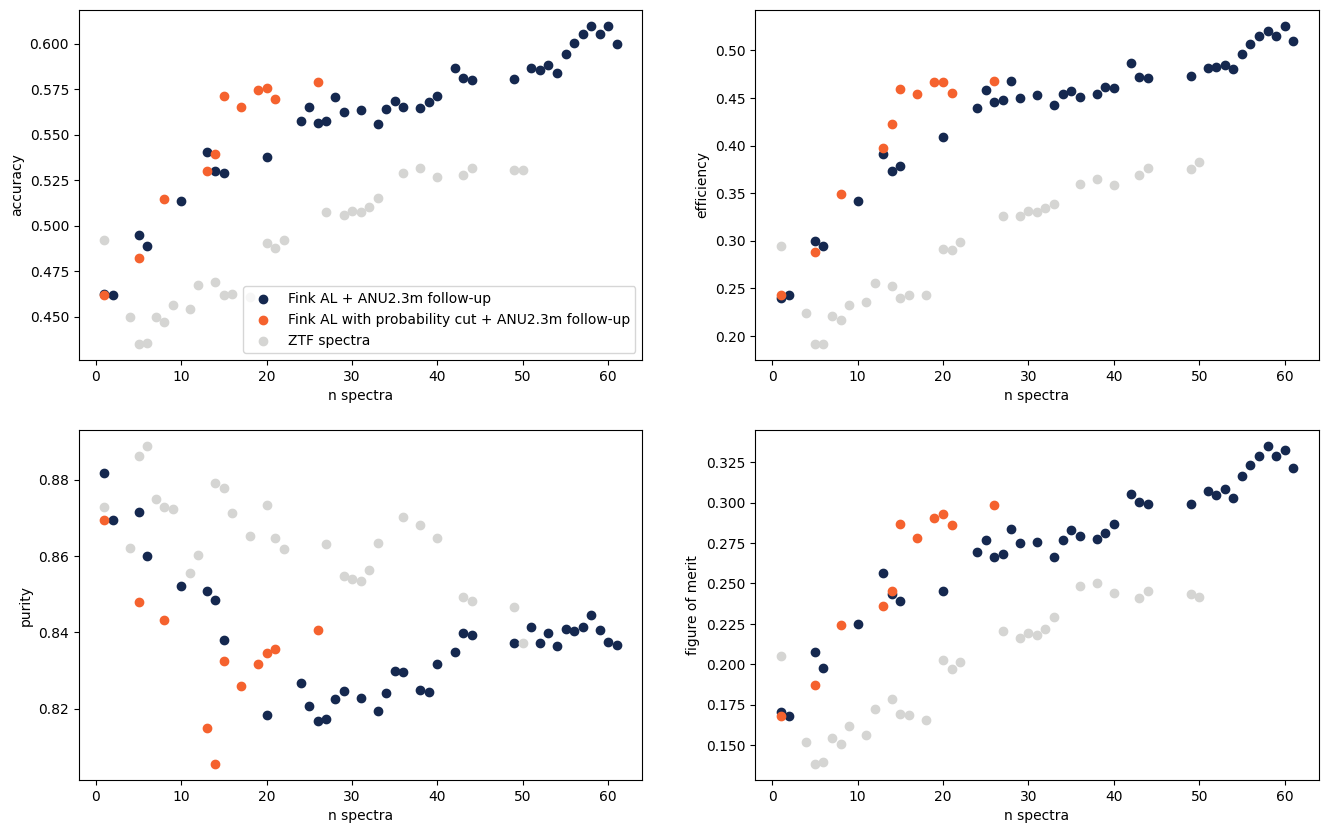

In [266]:
plot_metrics_listdf([metrics_all_pd,metrics_probacut,metrics_ztf],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'],varx='n spectra')

# combining our tags with ZTF ones

In [242]:
# convert to new_labels format
dic_ztf_labels_all = {}

all_dates = list(set( list(ztf_tns['discoveryjd+12_strfmt'].unique()) + list(new_labels.keys()) ))
all_dates.sort()

ztf_tns['discoveryjd+12'] = ztf_tns['discoveryjd+12'].astype(str)

for dat in all_dates:
    
    try:
        tmp_arr_all = new_labels[dat]
    except Exception:
        tmp_arr_all = []
        # print('no Fink')
    
    if len(ztf_tns[ztf_tns['discoveryjd+12_strfmt']==dat])<1:
        dummy = []
        # print('No ZTF')
    sel = ztf_tns[ztf_tns['discoveryjd+12_strfmt']==dat]
    tmp_arr_ztf = sel[['Disc. Internal Name','type AL','discoveryjd+12']].to_numpy()

    if len(tmp_arr_all)>0 and len(new_labels[dat])>0:
        arr_out = np.concatenate([tmp_arr_ztf, tmp_arr_all])
    elif len(tmp_arr_all)>0:
        arr_out = tmp_arr_all
    elif len(tmp_arr_ztf)>0:
        arr_out = tmp_arr
        
    dic_ztf_labels_all[dat] = arr_out
    

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_16687/3721764660.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_tns['discoveryjd+12'] = ztf_tns['discoveryjd+12'].astype(str)


In [243]:
metrics_ztf_fink, probabilities_list_ztf_fink = AL_loop(dic_ztf_labels_all, train_for_loop, dir_suffix='ZTF_Fink', proba_cut = False)

20230921
Proba [[0.374 0.626]]
    train_updated.shape =  (41, 15)
   res =  [np.float64(0.4623931623931624), np.float64(0.23944549464398235), np.float64(0.8816705336426914), np.float64(0.17071160968989363)]
20230925
Proba [[0.479 0.521]]
    train_updated.shape =  (42, 15)
   res =  [np.float64(0.461965811965812), np.float64(0.2432262129804663), np.float64(0.8693693693693694), np.float64(0.16765235394724995)]
20230928
20231005
Proba [[0.256 0.744]
 [0.609 0.391]
 [0.31  0.69 ]]
    train_updated.shape =  (45, 15)
   res =  [np.float64(0.4948717948717949), np.float64(0.29930686830497794), np.float64(0.8715596330275229), np.float64(0.20754855831367086)]
20231006
Proba [[0.624 0.376]]
    train_updated.shape =  (46, 15)
   res =  [np.float64(0.4888888888888889), np.float64(0.2942659105229994), np.float64(0.860036832412523), np.float64(0.19772975570394344)]
20231009
Proba [[0.416 0.584]
 [0.168 0.832]
 [0.469 0.531]
 [0.572 0.428]]
    train_updated.shape =  (50, 15)
   res =  [np.float64

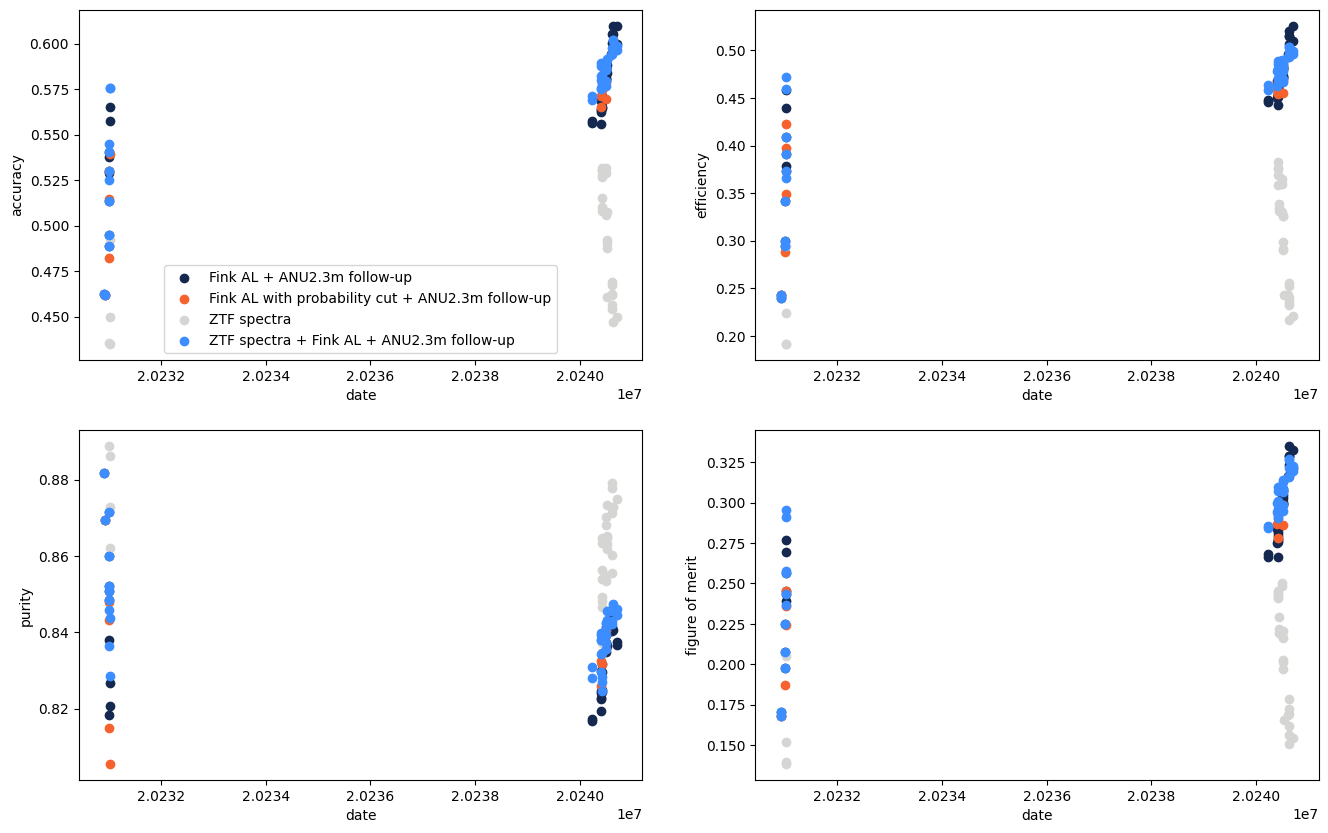

In [271]:
# for combined dates, it doesnt make sense to use the counter....
plot_metrics_listdf([metrics_all_pd,metrics_probacut,metrics_ztf,metrics_ztf_fink],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra', 'ZTF spectra + Fink AL + ANU2.3m follow-up'],suffix='mixedsamples',varx='date')

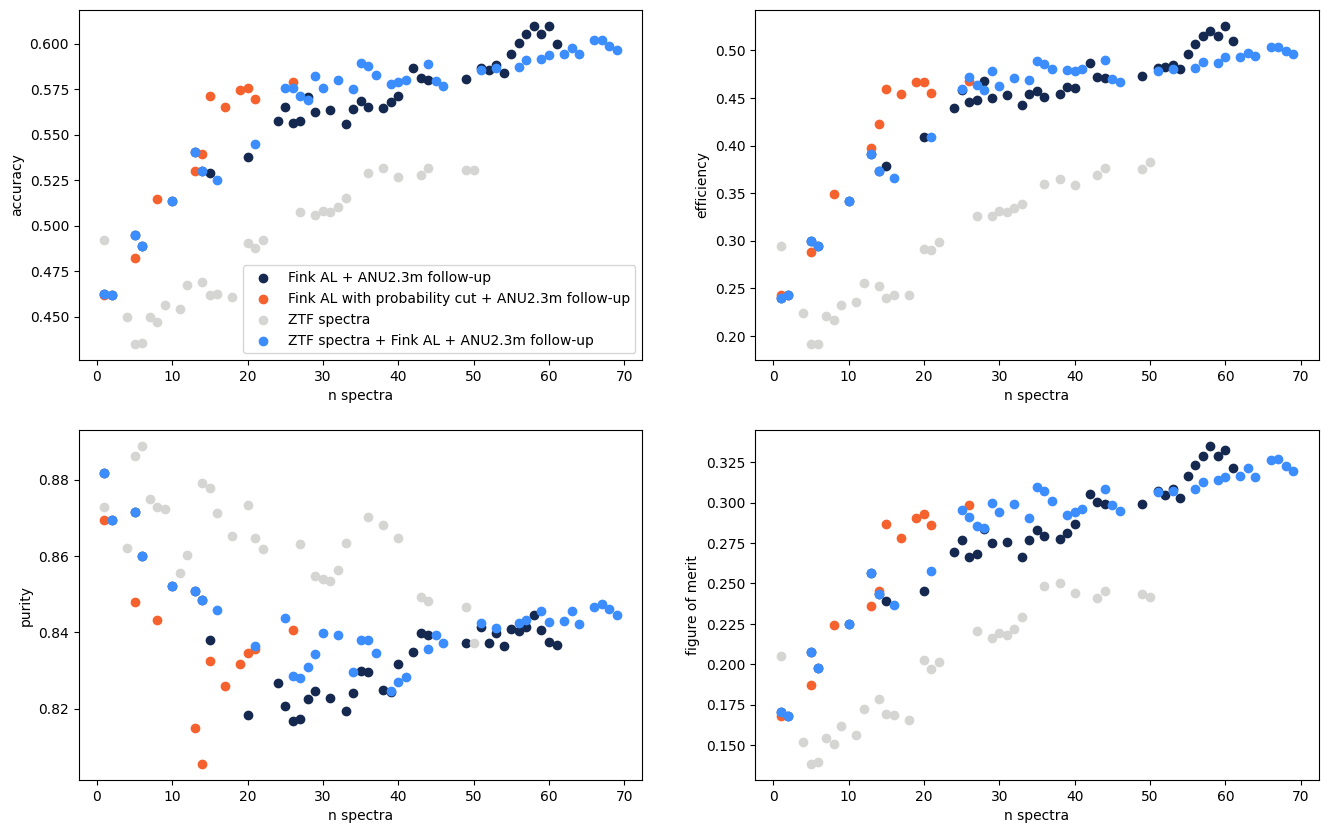

In [254]:
plot_metrics_listdf([metrics_all_pd,metrics_probacut,metrics_ztf,metrics_ztf_fink],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra', 'ZTF spectra + Fink AL + ANU2.3m follow-up'],varx='n spectra',suffix='mixedsamples')